In [1]:
#Import relevant libraries
import astropy
import numpy as np
import ccdproc
import os
import glob
import matplotlib.pyplot as plt
from astropy.nddata import CCDData
import scipy

In [2]:

#We repeat the same steps for the V band image production as we did for the B band image production
V = astropy.nddata.CCDData.read('C:/Users/steve/OneDrive - University of Birmingham/LH Observatory Laboratory/Glob Cluter Final Code/GlobClusters/MasterScienceV.fits', unit='adu')

B = astropy.nddata.CCDData.read('C:/Users/steve/OneDrive - University of Birmingham/LH Observatory Laboratory/Glob Cluter Final Code/GlobClusters/MasterScienceB.fits', unit='adu')

V = np.array(V)
B = np.array(B)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [3]:
from skimage import data, draw
from skimage.registration import phase_cross_correlation
from scipy import ndimage



detected_shift = phase_cross_correlation(np.array(B), np.array(V), upsample_factor = 1000)
print(detected_shift[0])
V = scipy.ndimage.shift(V, detected_shift[0])


[-3.751 10.623]


In [5]:
Vccd = CCDData(V, unit="adu")
hdu1 = CCDData.to_hdu(Vccd)
hdu1.writeto('MasterScienceVshift.fits', overwrite = True)

[[  0.           0.           0.         ... 330.58141792 327.89234656
  329.02945121]
 [  0.           0.           0.         ... 330.15130858 334.57564065
  326.82825301]
 [  0.           0.           0.         ... 331.96787356 328.8265081
  328.28060763]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(4096, 4096)
322.158513295919
144.0340528505893


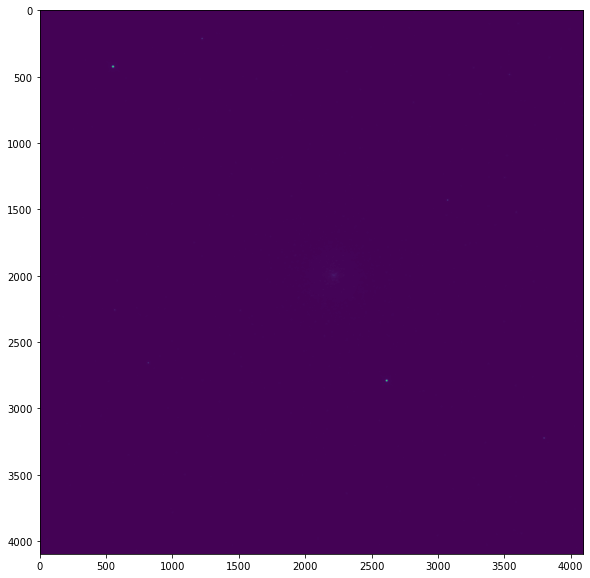

In [6]:
## Show all the B Range science 

print(V)
print(V.shape)
plt.figure(1,(10,10))
plt.imshow(V)

mean_V = np.mean(V)
std_V = np.std(V)
print(mean_V)
print(std_V)

In [7]:
detected_shift = phase_cross_correlation(np.array(B), np.array(V), upsample_factor = 1000)
print(detected_shift[0])

[ 0.012 -0.033]


322.22940265817033
3.315165808663122


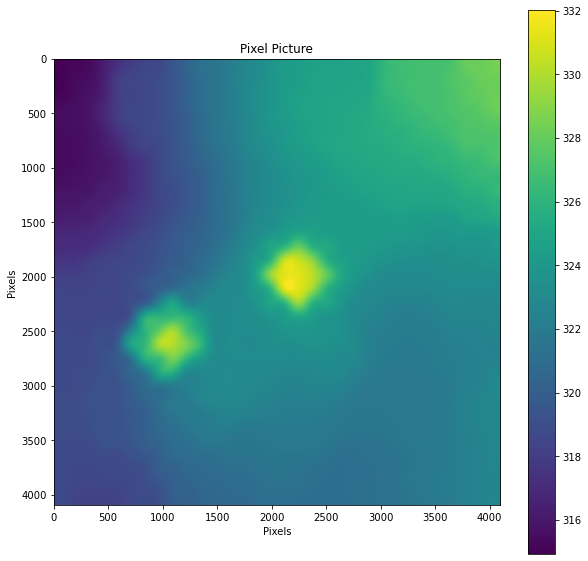

In [8]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(V, (128, 128), filter_size=(5,5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

print(bkg.background_median)  
print(bkg.background_rms_median)  

bkg_median = bkg.background_median
bkg_rms = bkg.background_rms
bkg_rms_median = bkg.background_rms_median

plt.figure(1,(10,10))
plt.title('Pixel Picture')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.imshow(bkg.background)

cbar = plt.colorbar()

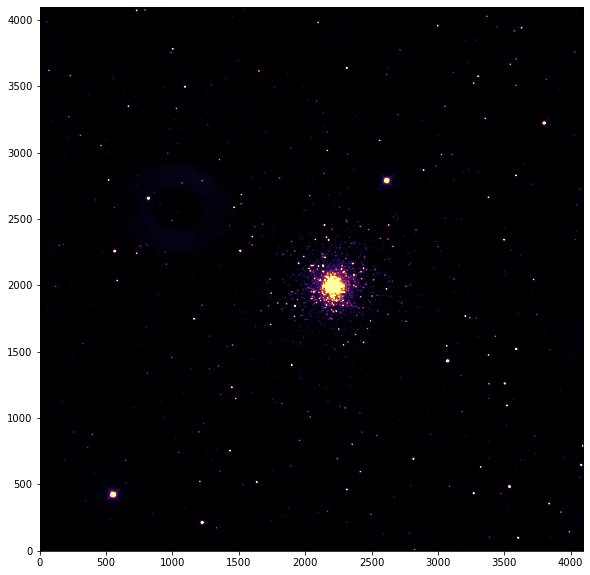

In [9]:
plt.figure(1,(10,10))
plt.imshow(V-bkg.background, vmin=0, vmax=200, cmap='inferno', origin='lower')

Text(0.5, 1.0, 'Segmentation Image')

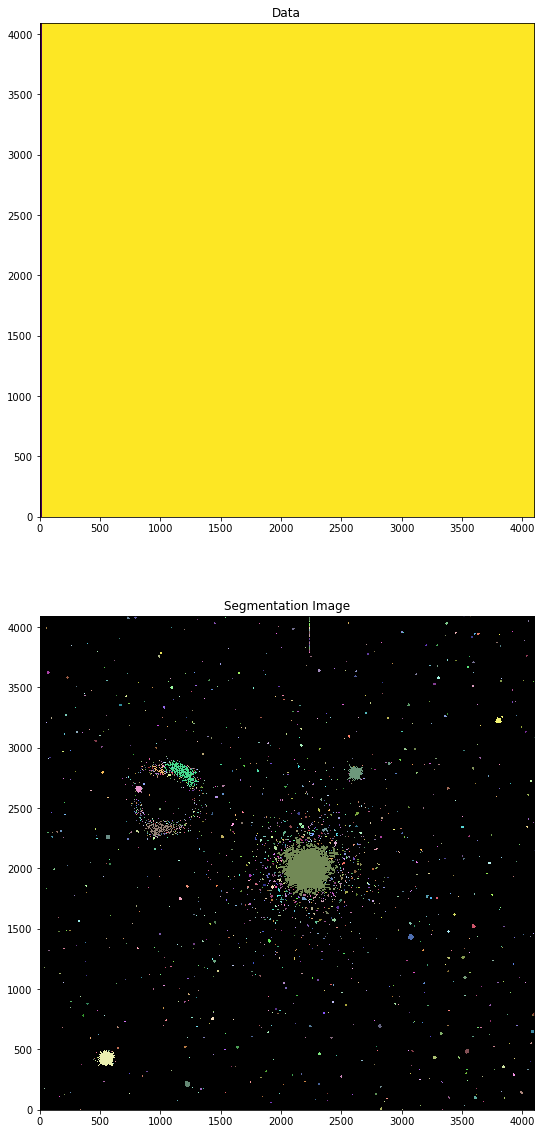

In [10]:
from photutils.utils import calc_total_error
from photutils.segmentation import detect_threshold
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_sources
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

threshold = detect_threshold(V, nsigma=3.)

threshold = bkg.background + (2.0 * bkg_rms) 

sigma = 2.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(V, threshold, npixels=3, kernel=kernel)

norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
ax1.imshow(V, vmin=10, vmax=90, origin='lower')
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')

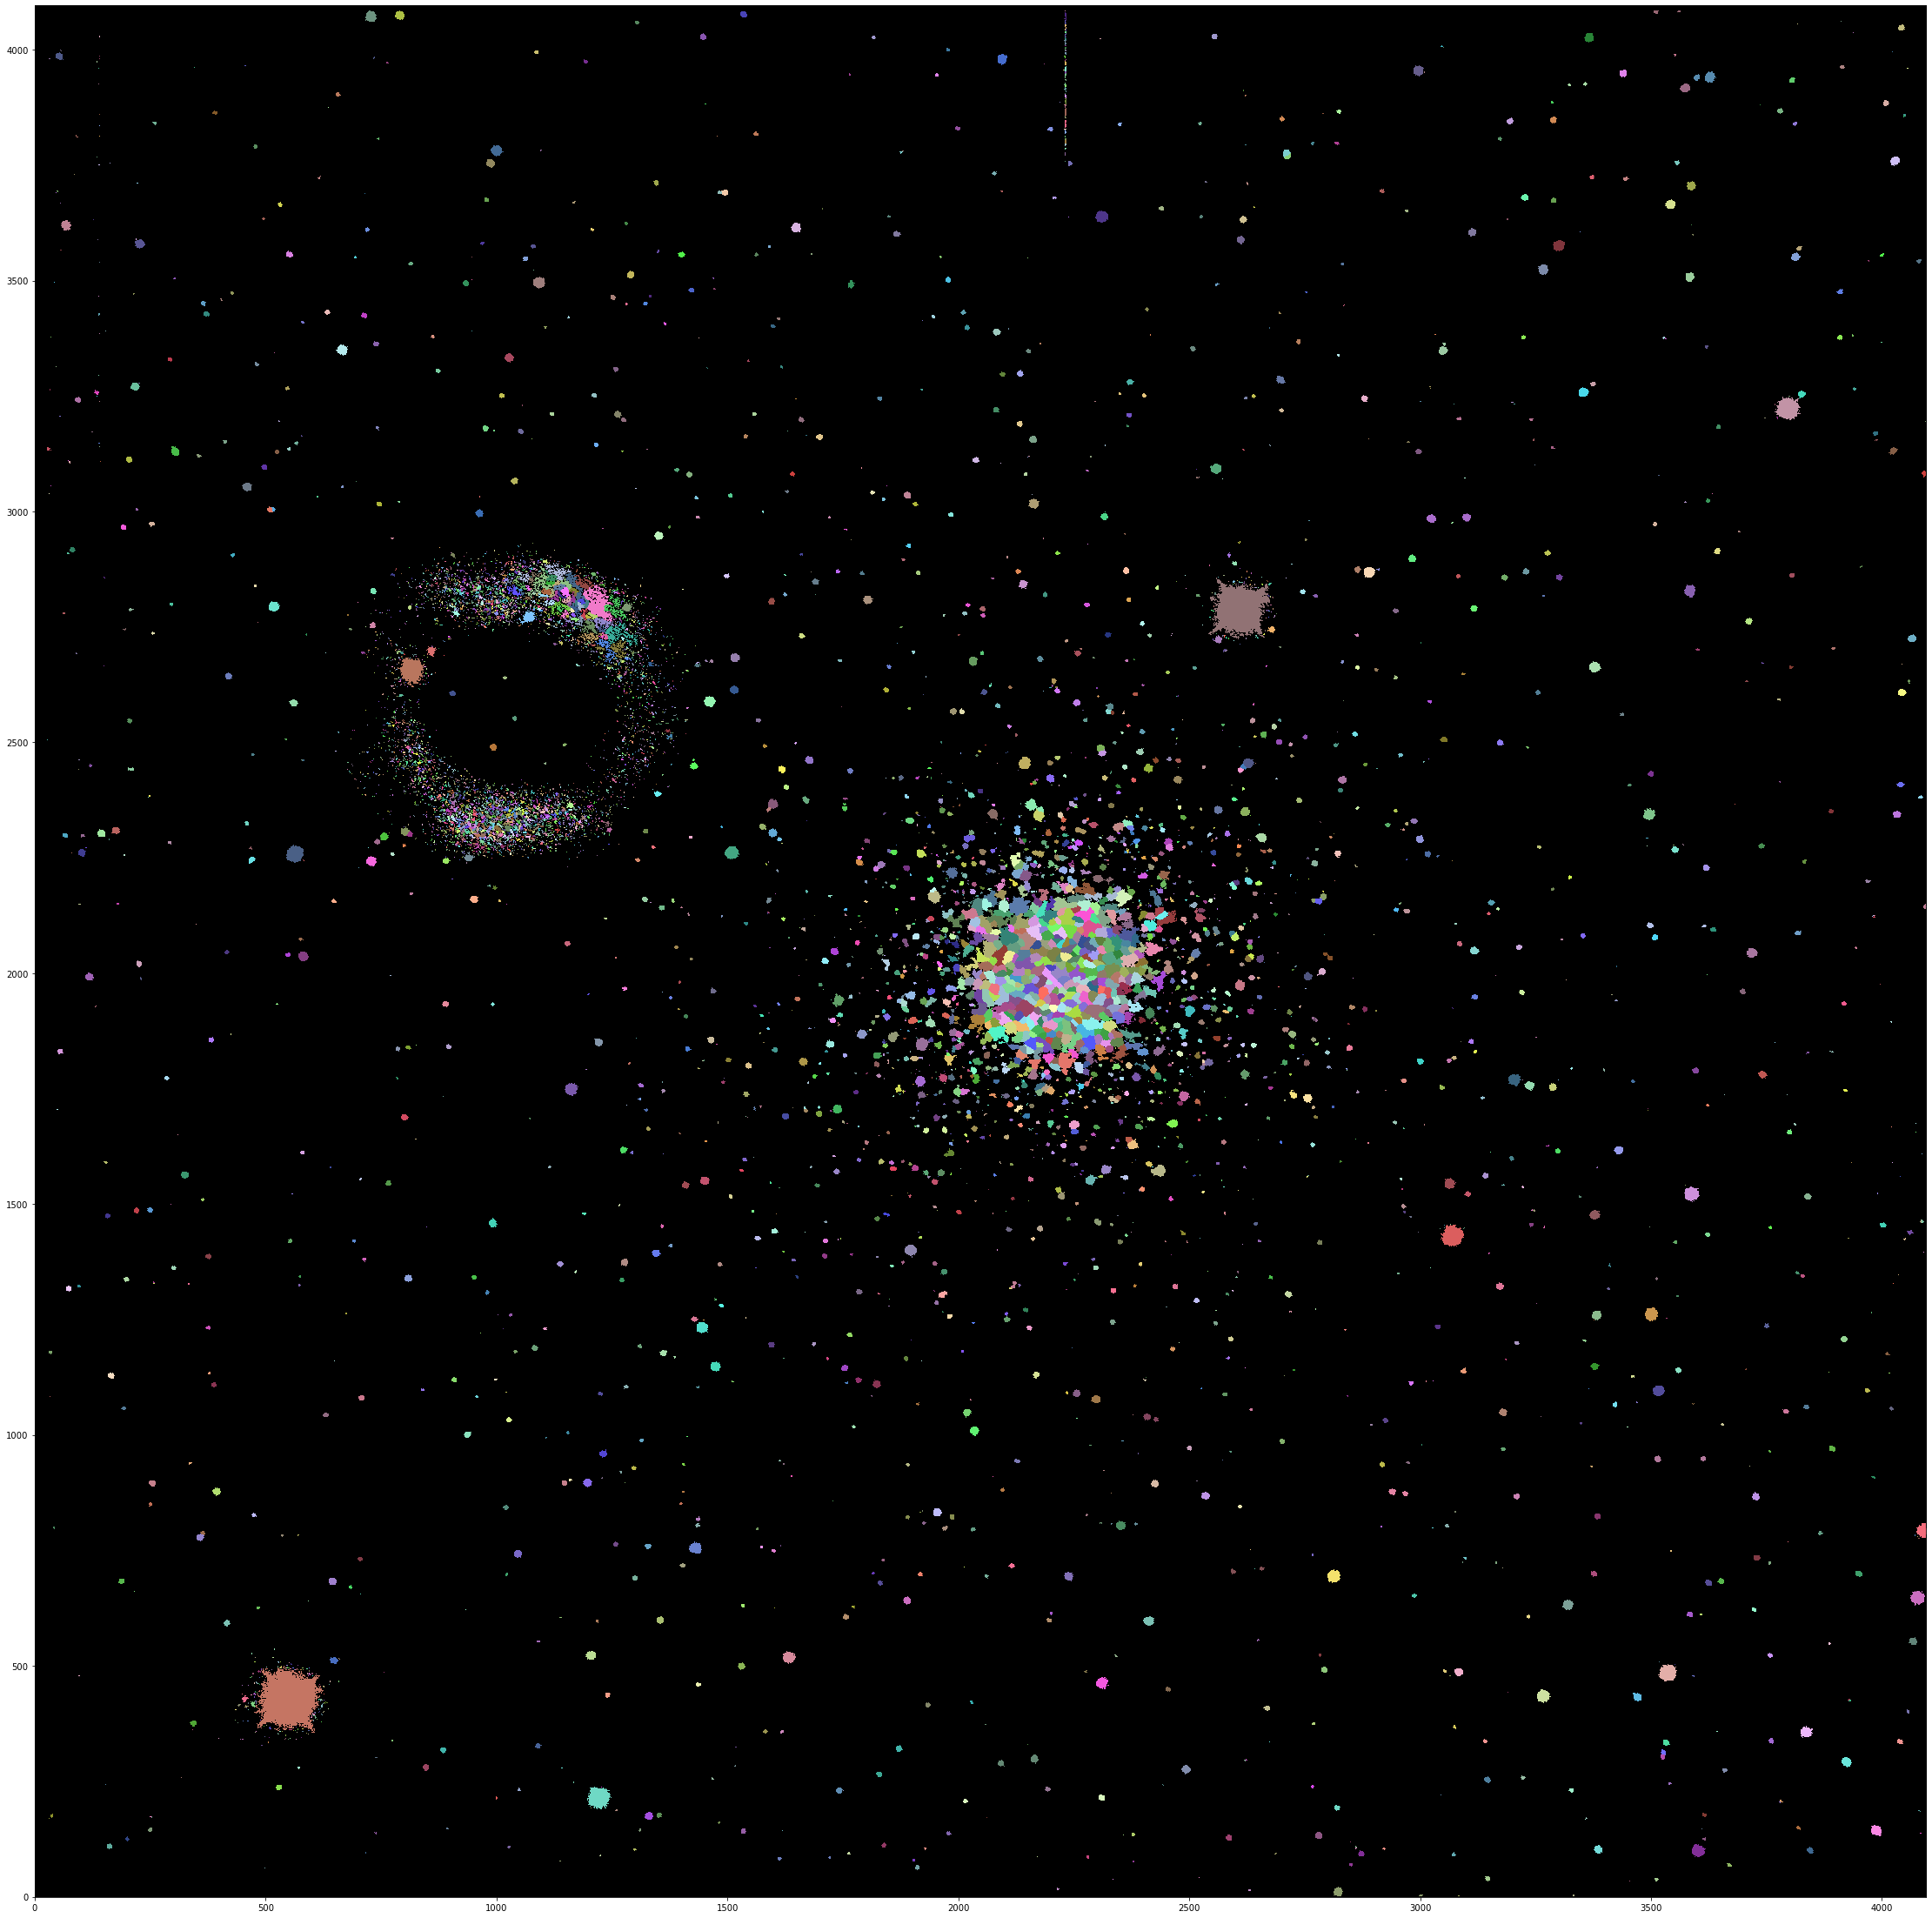

In [11]:
#Notice the dust artifact which will be mentioned in the final report

from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(V, segm, npixels=3, kernel=kernel,
                               nlevels=32, contrast=0.001)

plt.figure(1,(40,40))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')

In [12]:
from photutils.segmentation import source_properties
error = calc_total_error(V, bkg_error = bkg_rms, effective_gain = 2.2)
table_V = source_properties(V - bkg.background, segm_deblend, error)

        Use `~photutils.segmentation.SourceCatalog` instead. [warnings]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


In [13]:
tblV = table_V.to_table()
tblV.write('table_V', format = 'ascii', overwrite = True)


In [ ]:
#from astropy.table import Table

#tblV = Table.read('table_V', format='ascii')
#tblV.show_in_notebook()